In [1]:
# import libraries
import numpy as np
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline

In [37]:
# read datasets
regular_seasons = pd.read_csv("datasets/kaggle_data/RegularSeasonCompactResults.csv")
teams = pd.read_csv("datasets/kaggle_data/Teams.csv")

In [38]:
regular_seasons.head()

,Season,Daynum,Wteam,Wscore,Lteam,Lscore,Wloc,Numot
0,1985,20,1228,81,1328,64,N,0
1,1985,25,1106,77,1354,70,H,0
2,1985,25,1112,63,1223,56,H,0
3,1985,25,1165,70,1432,54,H,0
4,1985,25,1192,86,1447,74,H,0


In [5]:
# filtration function
def filter_season(data, season):
    return data[data["Season"] == season]
    
def filter_into_seasons(data):
    # buffer to hold list of seasons
    season_arr = []
    
    # min and max
    max_season = data["Season"].max()
    min_season = data["Season"].min()
    
    # filter
    for season in range(min_season, max_season + 1):
        season_arr.append(filter_season(data, season))
        
    return season_arr

In [479]:
# filtered seasons
seasons = filter_into_seasons(regular_seasons)

---

### 1) Create Home and Home Pairs

In [ ]:
home_and_home_list = []

i = 0
for season in seasons:
    print i
    
    for index, row in season.iterrows():
        w_team = row["Wteam"]
        l_team = row["Lteam"]
        w_loc  = row["Wloc"]
        
        # construct location
        if w_loc == "H":
            l_loc = "A"
        elif w_loc == "A":
            l_loc = "H"
        # ignore neutral site
        elif w_loc == "N":
            l_loc = "N/a"
            w_loc = "N/a"
            
        # wteam wins both 
        case_1 = ((season['Wteam'] == w_team) & (season['Lteam'] == l_team) & (season['Wloc'] == l_loc))
        # wteam wins one and lteam wins the other
        case_2 = ((season['Wteam'] == l_team) & (season['Lteam'] == w_team) & (season['Wloc'] == w_loc))
 
        # opposite home and home game
        games = season[(case_1 | case_2)].index
        
        # if there is a home and home
        if games.shape[0] > 0:
   
            # add to pairs list
            min_index = min(index, games.values[0])
            max_index = max(index, games.values[0])
            home_and_home_list.append((min_index, max_index))

    i = i + 1

In [178]:
# generate pairs
home_and_home_pairs = pd.DataFrame(data = home_and_home_list, columns=["game1", "game2"])

In [188]:
home_and_home_pairs.to_csv("datasets/our_data/home_and_home_pairs_full.csv")

In [204]:
# drop dupicate rows
home_and_home_pairs_unique = home_and_home_pairs.drop_duplicates()

In [190]:
# test, see no more duplicates remain
print home_and_home_pairs_unique[((home_and_home_pairs_unique['game1'] == 1)&(home_and_home_pairs_unique['game2'] == 1262))]

   game1  game2
0      1   1262


In [205]:
# export to csv
home_and_home = home_and_home_pairs_unique
home_and_home.to_csv("datasets/our_data/home_and_home_pairs.csv")

In [211]:
# reset index
home_and_home = home_and_home.reset_index()

In [213]:
# drop index column
home_and_home = home_and_home.drop('index', 1)

In [217]:
home_and_home.to_csv("datasets/our_data/home_and_home_pairs.csv")

In [32]:
home_and_home = pd.read_csv("datasets/our_data/home_and_home_pairs.csv", index_col=0)
home_and_home.head()

,game1,game2
0,1,1262
1,4,1762
2,8,641
3,9,732
4,35,739


In [39]:
home_and_home["home_x"] = np.zeros(home_and_home.shape[0])
home_and_home["away_x"] = np.zeros(home_and_home.shape[0])

home_and_home.head()

,game1,game2,home_x,away_x
0,1,1262,0.0,0.0
1,4,1762,0.0,0.0
2,8,641,0.0,0.0
3,9,732,0.0,0.0
4,35,739,0.0,0.0


---

### 2) Get Home Team Results, Away Team Results

In [ ]:
# iterate games
for index, pair in home_and_home.iterrows():
    if index % 100 == 0:
        print index
    
    # games
    game_1 = regular_seasons.loc[pair[0]]
    game_2 = regular_seasons.loc[pair[1]]
    
    # game 1 scoring dif
    if game_1["Wloc"] == "H":
        # home team wins game 1
        game_1_dif = game_1["Wscore"] - game_1["Lscore"]
    else:
        # away team wins game 1
        game_1_dif = game_1["Lscore"] - game_1["Wscore"]
    
    # game 2 scoring dif
    if game_2["Wloc"] == "H":
        # home team wins game 2
        game_2_dif = game_2["Lscore"] - game_2["Wscore"]
    else:
        # away team wins game 2
        game_2_dif = game_2["Wscore"] - game_2["Lscore"]
    
    home_and_home.loc[index, "home_x"] = game_1_dif
    home_and_home.loc[index, "away_x"]= game_2_dif

In [42]:
home_and_home.head()

,game1,game2,home_x,away_x
0,1,1262,7.0,-5.0
1,4,1762,12.0,10.0
2,8,641,18.0,11.0
3,9,732,8.0,-9.0
4,35,739,45.0,-8.0


In [43]:
home_and_home["away_win"] = np.zeros(home_and_home.shape[0])
for index, pair in home_and_home.iterrows():
    if pair["away_x"] > 0:
        home_and_home.loc[index, "away_win"] = 1
    else:
        home_and_home.loc[index, "away_win"] = 0

In [44]:
home_and_home.head()

,game1,game2,home_x,away_x,away_win
0,1,1262,7.0,-5.0,0.0
1,4,1762,12.0,10.0,1.0
2,8,641,18.0,11.0,1.0
3,9,732,8.0,-9.0,0.0
4,35,739,45.0,-8.0,0.0


In [45]:
home_and_home.to_csv("datasets/our_data/home_and_home_data.csv")

### 3) Fit Logistic Regression Model

In [46]:
from sklearn.linear_model import LogisticRegression as LogReg
from sklearn.cross_validation import train_test_split

In [55]:
# train_x and train_y
train_x = home_and_home["home_x"].values.reshape((home_and_home.shape[0],1))
train_y = home_and_home["away_win"].values

# fit log_reg_model
log_reg_model = LogReg()
log_reg_model.fit(train_x, train_y)

print log_reg_model.coef_
print log_reg_model.intercept_

[[ 0.05457784]]
[-0.79096196]


In [56]:
from math import exp

In [57]:
min_x = train_x.min()
max_x = train_x.max()

samp_prob = np.zeros(max_x - min_x + 1)
i = 0
for x in range(int(min_x), int(max_x) + 1):
    
    count = train_data[train_data["home_x"] == x]
    wins = count[count["away_win"] == 1]
    
    if count.shape[0] > 0:
        samp_prob[i] =  float(wins.shape[0]) / count.shape[0] 
        i = i + 1

/Users/robertshaw/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:4: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


In [59]:
home_and_home.to_csv("datasets/our_data/sample_p_away_win_given_home_x.csv")

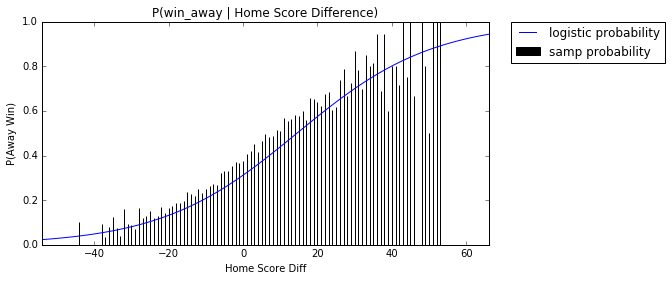

In [60]:
# init
fig = plt.figure(figsize=(8, 4))
ax = fig.add_subplot(111)
min_x = train_x.min()
max_x = train_x.max()
x_values = np.array(range(int(min_x), int(max_x) + 1))

# calculate probabilities
odds = np.exp(x_values * log_reg_model.coef_ + log_reg_model.intercept_)
log_prob = odds / (1. + odds)

# plot
ax.plot(x_values, log_prob[0], label="logistic probability")
ax.bar(x_values, samp_prob, .005, color="black", label="samp probability")
ax.set_xlabel("Home Score Diff")
ax.set_ylabel("P(Away Win)")
ax.set_title("P(win_away | Home Score Difference)")
ax.set_xlim([min_x, max_x])
ax.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)

In [655]:
# p win away given home scoring differential
x_values = np.array(range(-100, 101))
odds = np.exp((x_values) * log_reg_model.coef_ + log_reg_model.intercept_)
prob = odds / (1. + odds)      

s_x_h = pd.DataFrame(data=prob[0], index=x_values, columns=["prob"])

In [656]:
s_x_h.loc[14]

prob    0.493282
Name: 14, dtype: float64

We see s_x_h = .5 (P(win away | home scoring differential)) when x = 14.
Thus, home court advantage is 7 points.

In [657]:
home_court_advantage = 7

In [663]:
x_values = np.array(range(-100, 101))
odds = np.exp((x_values + home_court_advantage) * log_reg_model.coef_ + log_reg_model.intercept_)
prob = odds / (1. + odds)                  
                    
probability_better_given_home_dif = prob

In [664]:
probability_better_given_home_dif_df = pd.DataFrame(data=probability_better_given_home_dif[0], index=x_values, columns=["prob"])

In [665]:
probability_better_given_home_dif_df.to_csv("datasets/our_data/r_x_h")

In [666]:
probability_better_given_home_dif_df.head()

,prob
-100,0.002824
-99,0.002982
-98,0.003149
-97,0.003325
-96,0.003511


$r_x^H = s_{x+h}^H$ 

In [667]:
# probability better given home dif of x 
r_x_h = probability_better_given_home_dif_df

$r_x^A = 1 - r_{-x}^H$

In [668]:
# probability better given away dif of x
# r_x_a = 1 - r_-x_h
helper_df = 1. - r_x_h
helper_df.index = range(100, -101, -1)
r_x_a = helper_df.sort_index()
r_x_a.to_csv("datasets/our_data/r_x_a")

$r_x^N = r_{x+h}^H = s_{x + 2h}^H$

In [669]:
# probability better given neutral dif of x
x_values = np.array(range(-100, 101))
odds_neutral = np.exp((x_values + 2 * home_court_advantage) * log_reg_model.coef_ + log_reg_model.intercept_)
prob_neutral = odds_neutral / (1. + odds_neutral)                  
                    
r_x_n = pd.DataFrame(data=prob_neutral[0], index=x_values, columns=["prob"])
r_x_n.to_csv("datasets/our_data/r_x_n")

### 4) Generate Markov Chain Function

- Games Played Matrix

In [85]:
# counts of a teams wins and losses_
games_np = np.zeros((len(seasons), teams.shape[0]))

# iterate seasons
i = 0
for season in seasons:
    games = 0
    
    # count wins/losses
    win_counts = season["Wteam"].value_counts(sort=False) 
    loss_counts = season["Lteam"].value_counts(sort=False) 
    
    # iterate teams
    j = 0
    for team in range(teams["Team_Id"].min(), teams["Team_Id"].max() + 1):           
        # if a team has a win in the year, extract from wins count
        if team in win_counts.index:
            games = games + win_counts[team]
            
        # if a team has a loss in the year, extract from loss count
        if team in loss_counts.index:
            games = games + loss_counts[team]
        
        # update buffer
        if games == 0:
            games_np[i, j] = np.nan
        else:
            games_np[i, j] = games
                    
        j = j + 1
        
        games = 0
                    
    i = i + 1

In [87]:
games_matrix = pd.DataFrame(data=games_np, columns=teams["Team_Id"], index=range(1985, 2017))
games_matrix.to_csv("datasets/our_data/games_matrix")

In [88]:
games_matrix.head()

Team_Id,1101,1102,1103,1104,1105,1106,1107,1108,1109,1110,...,1455,1456,1457,1458,1459,1460,1461,1462,1463,1464
1985,NaN,24.0,23.0,30.0,NaN,24.0,NaN,25.0,24.0,25.0,...,29.0,27.0,NaN,26.0,NaN,NaN,26.0,28.0,23.0,27.0
1986,NaN,25.0,25.0,30.0,NaN,24.0,NaN,25.0,24.0,25.0,...,27.0,27.0,NaN,25.0,NaN,NaN,29.0,27.0,23.0,26.0
1987,NaN,23.0,26.0,30.0,NaN,25.0,NaN,25.0,24.0,23.0,...,31.0,25.0,26.0,28.0,NaN,NaN,30.0,26.0,25.0,25.0
1988,NaN,24.0,25.0,30.0,NaN,25.0,NaN,26.0,24.0,27.0,...,28.0,27.0,26.0,28.0,NaN,25.0,30.0,27.0,26.0,27.0
1989,NaN,24.0,28.0,30.0,NaN,26.0,NaN,24.0,24.0,25.0,...,28.0,26.0,25.0,26.0,NaN,24.0,31.0,31.0,26.0,24.0


- Helper Functions

In [671]:
# extracts list of games 
def get_games(games, team_1, team_2):
    
    # filter team 1 wins/ losses
    team_1_win = games[(games["Wteam"] == team_1) & (games["Lteam"] == team_2)]
    team_1_loss = games[(games["Wteam"] == team_2) & (games["Lteam"] == team_1)]
    
    # filter location
    team_1_win_home = team_1_win[(team_1_win["Wloc"] == "H")]
    team_1_win_away = team_1_win[(team_1_win["Wloc"] == "A")]
    team_1_win_neutral = team_1_win[(team_1_win["Wloc"] == "N")]
    
    # filter location
    team_1_loss_home = team_1_loss[(team_1_loss["Wloc"] == "A")]
    team_1_loss_away = team_1_loss[(team_1_loss["Wloc"] == "H")]
    team_1_loss_neutral = team_1_loss[(team_1_loss["Wloc"] == "N")]
    
    # get score differences
    home_games = get_score_difs(team_1_win_home, team_1_loss_home)
    away_games = get_score_difs(team_1_win_away, team_1_loss_away)
    neutral_games = get_score_difs(team_1_win_neutral, team_1_loss_neutral)
    
    return home_games, away_games, neutral_games
            

# given dfs of games, extract scoring differences
def get_score_difs(wins, losses):
    # buffer to hold values
    arr = []
    
    # iter wins
    for index, game in wins.iterrows():
        # calc score differences
        dif = game["Wscore"] - game["Lscore"]
        arr.append(dif)
        
    # iter losses
    for index, game in losses.iterrows():
        # calc score differences 
        dif = game["Lscore"] - game["Wscore"]
        arr.append(dif)
        
    return arr

# extract probs team 2 > team 1
def extract_rxs(score_difs, probs):
    rxs = []
    for dif in score_difs:

        # prob(team 2 > team 1) = 1 - prob(team 1 > team 2)
        rxs.append(1. - probs.loc[int(dif)])
        
    return rxs


- Gen Markov Chain Function

In [284]:
import math

In [672]:
# generate markov chain
def gen_markov_chain_transition_matrix(season, teams, games_count, home_rx_matrix, away_rx_matrix, neutral_rx_matrix):
    played_game = []
    # filter teams with 0 games played
    for i in range(teams.shape[0]):
        if math.isnan(games_count.iloc[i]):
            played_game.append(False)
        else:
            played_game.append(True)
    
    # indexes
    rows = teams[played_game]
    columns = rows
    
    # probability matrix
    probs_np = np.zeros((rows.shape[0], columns.shape[0]))
    probs_df = pd.DataFrame(data=probs_np, columns=columns, index=rows)
    
    # calculate t_{i,j} for all i != j
    for index, row in probs_df.iterrows():        
        # games played
        n_i = float(games_count.loc[index])
        
        # team 1
        team_1 = index

        # filter team 1's games
        team_1_games = season[(season["Wteam"] == team_1) | (season["Lteam"] == team_1)]
        opponents = np.unique(team_1_games[["Wteam", "Lteam"]])

        # iterate all opponents
        for team_2 in opponents:
            home_difs, away_difs, neutral_difs = get_games(team_1_games, team_1, team_2)        

            # check for 0
            if (home_difs, away_difs, neutral_difs) == (None, None, None):
                probs[i, team_2 - 1101] = 0.

            else:
                # get rxs (probability team 2 better than team 1, given score dif)
                home_rxs = extract_rxs(home_difs, home_rx_matrix)
                away_rxs = extract_rxs(away_difs, away_rx_matrix)
                neutral_rxs = extract_rxs(neutral_difs, neutral_rx_matrix)

                # transition probability
                probs_df.set_value(team_1, team_2, (sum(home_rxs) + sum(away_rxs) + sum(neutral_rxs)) / n_i)
        
    # calculate t_{i,i}
    for index, row in probs_df.iterrows():
        team_1 = index
        
        # games played
        n_i = float(games_count.loc[index])

        # t_ii = 1 - sum_{j} t_ij
        probs_df.set_value(team_1, team_1, 1. - probs_df.loc[team_1, :].sum())
            
    return probs_df     

- Gen Stationary Distribution

In [646]:
from scipy.linalg import eig

In [680]:
# generate stationary distibution
def generate_stationary_distribution(probs, teams, games):
    eigenvalues, eigenvectors = eig(probs,left=True,right=False)

    # stationary distibution is primary eigenvector
    # pi = pi * P
    stationary = eigenvectors[:, 0]
    stationary = stationary / np.sum(stationary)
    
    # confirm 
    if stationary[np.iscomplex(stationary)].shape[0] == 0:
        # convert to reals
        stationary = stationary.astype(float)
    else:
        print "complex!!"

    played_game = []
    # filter teams with 0 games played
    for i in range(teams.shape[0]):
        if math.isnan(games.iloc[i]):
            played_game.append(False)
        else:
            played_game.append(True)

    # indexes of dataframe are only those teams who played games
    indexes = teams[played_game]["Team_Id"].values

    print indexes.shape
    print stationary.shape
    # return dataframe
    return pd.DataFrame(data=stationary, index = indexes, columns =["pi_i"])

- Test on 1985

In [ ]:
probs_1985 = gen_markov_chain_transition_matrix(seasons[0], teams["Team_Id"], games_matrix.iloc[0, :], r_x_h, r_x_a, r_x_n)

In [641]:
stationary_1985_df = generate_stationary_distribution(probs_1985, teams, games_matrix.iloc[0, :])

(1+0j)
(0,)


/Users/robertshaw/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:16: ComplexWarning: Casting complex values to real discards the imaginary part


In [642]:
stationary_1985_df.head()

,pi_i
1102,0.001977
1103,0.002041
1104,0.006740
1106,0.002103
1108,0.004213


In [643]:
stationary_1985_df.to_csv("datasets/our_data/pi_i_1985")

In [526]:
tourney_wins = pd.read_csv("datasets/our_data/tourney_wins_matrix", index_col=0)
in_tourney = pd.read_csv("datasets/our_data/in_tourney_matrix", index_col=0)

In [521]:
from sklearn.linear_model import LinearRegression as LinReg

In [534]:
in_tourney_1985 = in_tourney.loc[1985]
teams_in_tourney_1985 = in_tourney_1985[in_tourney_1985 == 1.].index

In [551]:
tourney_wins_1985_filt = tourney_wins.loc[1985, teams_in_tourney_1985]
print tourney_wins_1985_filt.shape

(64,)


In [557]:
pi_i_1985 = pd.read_csv("datasets/our_data/pi_i_1985", index_col=0)

pi_i_1985.index = pi_i_1985.index.astype(str)
pi_i_1985_filt = pi_i_1985.loc[teams_in_tourney_1985, "pi_i"]

(64,)


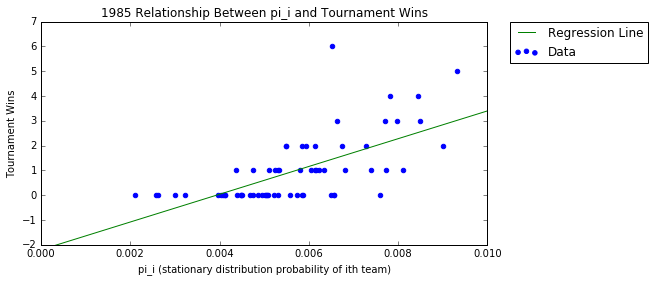

In [688]:
lin_reg = LinReg()
y = tourney_wins_1985_filt.values.reshape(64,1)
x = pi_i_1985_filt.values.reshape(64,1)
lin_reg.fit(x,y)


x_vals = np.array([0, .01])
y_vals = x_vals * lin_reg.coef_[0] + lin_reg.intercept_

fig = plt.figure(figsize=(8,4))
ax = fig.add_subplot(111)
ax.scatter(x, y, color="Blue", label="Data")
ax.plot(x_vals, y_vals, color="green", label="Regression Line")
ax.set_xlim([0, .01])
ax.set_ylim([-2,7])
ax.set_title("1985 Relationship Between pi_i and Tournament Wins")
ax.set_xlabel("pi_i (stationary distribution probability of ith team)")
ax.set_ylabel("Tournament Wins")
ax.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)

### 5) Gen Transition Matrix For All Years

In [ ]:
transition_matricies = []
stationary_distributions = []

i = 1985
for season in seasons:
    # generate transition matrix
    transition_matrix_df = gen_markov_chain_transition_matrix(season, teams["Team_Id"], games_matrix.iloc[i - 1985, :], r_x_h, r_x_a, r_x_n)
    
    # save as a file
    file_path = "datasets/our_data/{}_transition_matrix".format(i)
    transition_matrix_df.to_csv(file_path)
    
    # append to list
    transition_matricies.append(transition_matrix_df)
    
    # generate stationary distibution
    stationary_df = generate_stationary_distribution(transition_matrix_df, teams, games_matrix.iloc[i - 1985, :])
    
    # save as a file
    file_path = "datasets/our_data/{}_stationary_distribution".format(i)
    stationary_df.to_csv(file_path)
    
    # append to list
    stationary_distributions.append(stationary_df)
    
    print stationary_df.sum()
      
    i = i + 1 

In [689]:
tourney_wins = pd.read_csv("datasets/our_data/tourney_wins_matrix", index_col=0)
in_tourney = pd.read_csv("datasets/our_data/in_tourney_matrix", index_col=0)

In [730]:
import random

In [738]:
i = 1985
j = 0 
cutoff = .7

preds_train = []
resps_train = []

preds_cross = []
resps_cross = []

for season in seasons:
    # filter tourney wins
    cur_season_in_tourney = in_tourney.loc[i][in_tourney.loc[i] == 1].index
    cur_season_tourney_wins = tourney_wins.loc[i, cur_season_in_tourney]
    
    # filter current 
    pi = stationary_distributions[j].loc[cur_season_in_tourney.astype(int)]
    
    if random.uniform(0,1) < .7:
        preds_train.append(pi)
        resps_train.append(cur_season_tourney_wins)
    else:
        preds_cross.append(pi)
        resps_cross.append(cur_season_tourney_wins) 
    
    i = i + 1
    j = j + 1

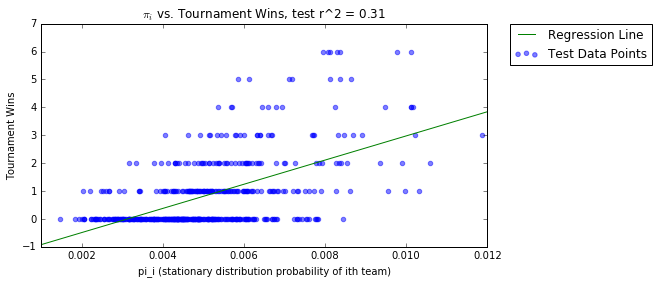

In [752]:
# train test split
x_train = pd.concat(preds_train).values
y_train = pd.concat(resps_train).values
x_train = x_train.reshape(x_train.shape[0],1)
y_train = y_train.reshape(y_train.shape[0],1)

x_cross = pd.concat(preds_cross).values
y_cross = pd.concat(resps_cross).values
x_cross = x_cross.reshape(x_cross.shape[0],1)
y_cross = y_cross.reshape(y_cross.shape[0],1)

# fit model to test
lin_reg = LinReg()
lin_reg.fit(x_train,y_train)
test_r2 = lin_reg.score(x_cross, y_cross)

# line to plot
x_vals = np.array([0, .02])
y_vals = x_vals * lin_reg.coef_[0] + lin_reg.intercept_

# init plot
fig = plt.figure(figsize=(8,4))
ax = fig.add_subplot(111)

# scatter and plot line
ax.scatter(x_cross, y_cross, color="Blue", label="Test Data Points", alpha=.5)
ax.plot(x_vals, y_vals, color="green", label="Regression Line")

# format axis
ax.set_xlim([.001, .012])
ax.set_ylim([-1,7])
ax.set_title("$\pi_i$ vs. Tournament Wins, test r^2 = {}".format(round(test_r2, 2)))
ax.set_xlabel("pi_i (stationary distribution probability of ith team)")
ax.set_ylabel("Tournament Wins")
ax.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)